In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached tensorflow-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl (516.2 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not 

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/MOT/'

/content/drive/My Drive/MOT


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/My Drive/MOT/models/research
  Using cached tensorflow-2.7.0-cp37-cp37m-manylinux2010_x86_64.whl (489.6 MB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1683460 sha256=d0455607072027971cf0cbd7e66e20ad9fb24a3853f905fe33f0aff1d930ded4
  Stored in directory: /tmp/pip-ephem-wheel-cache-0mgdijns/wheels/de/4c/bb/8a88ed0cc30676cefc0f1afd0bdd067e5a1e8ed3f2f829da17
Successfully built object-detection
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall:

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import argparse
#import imutils
import time

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
! pip install opencv-python==4.0.0.21

  Using cached opencv_python-4.0.0.21-cp37-cp37m-manylinux1_x86_64.whl (25.4 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.62
    Uninstalling opencv-python-4.5.5.62:
      Successfully uninstalled opencv-python-4.5.5.62
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lvis 0.5.3 requires opencv-python>=4.1.0.25, but you have opencv-python 4.0.0.21 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import cv2
print(cv2.__version__)

4.0.0


In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [ ]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hourglass104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_without_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

if model_display_name == 'centernet_with_keypoints':
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
else:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-01-06 20:25:53--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.195.128, 2607:f8b0:4001:c11::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426100886 (1.3G) [application/x-tar]
Saving to: ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz.8’

centernet_hg104_512 100%[===================>]   1.33G   105MB/s    in 16s     

2022-01-06 20:26:09 (82.8 MB/s) - ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz.8’ saved [1426100886/1426100886]



In [ ]:
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
                                model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'



# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
import os
print(os.getcwd())

/content/drive/My Drive/MOT


In [ ]:
#label_map_path = configs['eval_input_config'].label_map_path
label_map_path='./models/research/label_map.txt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [ ]:
#print(type(label_map))
print(category_index)
print(label_map_dict)


{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

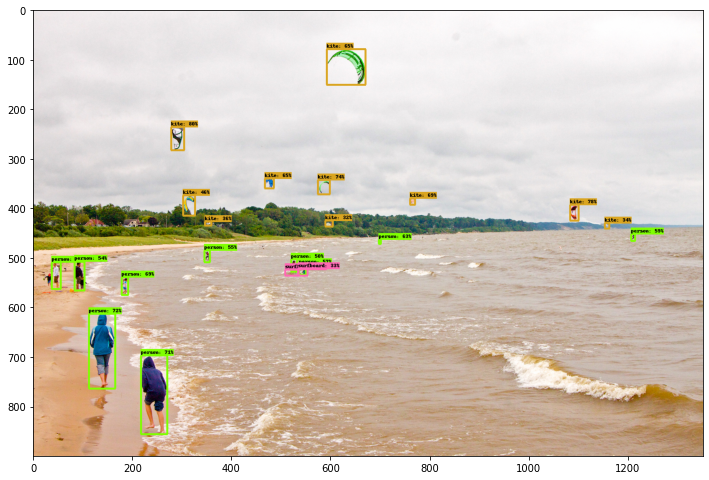

In [ ]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

(1238, 1650, 3)


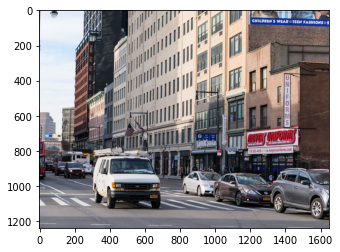

In [ ]:
img=plt.imread('./car.jpg')
print(img.shape)

plt.imshow(img)
plt.show()

In [ ]:
input_tensor = tf.convert_to_tensor(np.expand_dims(img, 0), dtype=tf.float32)

detections, predictions_dict, shapes = detect_fn(input_tensor)

#print(detections)


In [ ]:
print(predictions_dict.keys())
#print(predictions_dict['object_center'])
print(shapes)

dict_keys(['object_center', 'box/scale', 'box/offset', 'extracted_features', 'preprocessed_inputs'])
tf.Tensor([384 512   3], shape=(3,), dtype=int32)


In [ ]:
boxes=detections['detection_boxes'][0].numpy()
scores=detections['detection_scores'][0].numpy()
classes=(detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
print(boxes.shape)
print(boxes[0,:])
print(scores.shape)
print(classes.shape)
H_or,W_or=img.shape[:2]
print(H_or,W_or)

(100, 4)
[0.7228691  0.7972883  0.95534724 0.99651456]
(100,)
(100,)
1238 1650


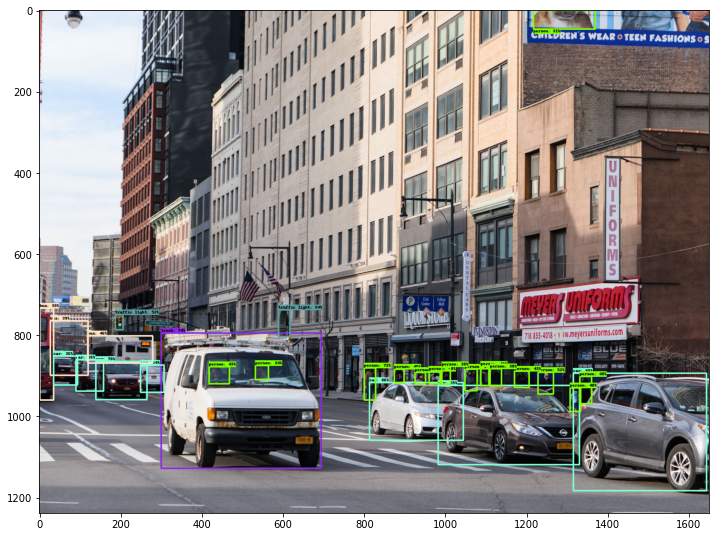

In [ ]:

label_id_offset = 1
image_np_with_detections = img.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
video_path = "./video_data/Test_video.mp4"
from google.colab.patches import cv2_imshow

In [ ]:
! git clone https://github.com/adipandas/multi-object-tracker
%cd multi-object-tracker

!pip install -r requirements.txt
!pip install -e. 

fatal: destination path 'multi-object-tracker' already exists and is not an empty directory.
/content/drive/My Drive/MOT/multi-object-tracker
  Using cached importlib_metadata-4.2.0-py3-none-any.whl (16 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.
Obtaining file:///content/drive/My%20Drive/MOT/multi-object-tracker
  Attempting uninstall: multi-object-tracker
    Found existing installation: multi-object-tracker 0.0.1
    Can't uninstall 'multi-object-tracker'. No files were found to uninstall.
  Running setup.py develop fo

In [ ]:
!pip install ipyfilechooser

In [ ]:
from motrackers import CentroidTracker, CentroidKF_Tracker, SORT, IOUTracker
from motrackers.utils import draw_tracks
import ipywidgets as widgets
from google.colab.patches import cv2_imshow

In [ ]:
chosen_tracker = widgets.Select(
    options=["CentroidTracker", "CentroidKF_Tracker", "SORT", "IOUTracker"],
    value='CentroidTracker',
    rows=5,
    description='MOTracker:',
    disabled=False
)
chosen_tracker

Select(description='MOTracker:', options=('CentroidTracker', 'CentroidKF_Tracker', 'SORT', 'IOUTracker'), valu…

In [ ]:
if chosen_tracker.value == 'CentroidTracker':
    tracker = CentroidTracker(max_lost=0, tracker_output_format='mot_challenge')
elif chosen_tracker.value == 'CentroidKF_Tracker':
    tracker = CentroidKF_Tracker(max_lost=0, tracker_output_format='mot_challenge')
elif chosen_tracker.value == 'SORT':
    tracker = SORT(max_lost=3, tracker_output_format='mot_challenge', iou_threshold=0.3)
elif chosen_tracker.value == 'IOUTracker':
    tracker = IOUTracker(max_lost=2, iou_threshold=0.5, min_detection_confidence=0.4, max_detection_confidence=0.7,
                         tracker_output_format='mot_challenge')
else:
    print("Please choose one tracker from the above list.")

In [ ]:
print(chosen_tracker.value)


def change_format_of_bbox(bboxes,image):

  new_bbox=[]

  H,W=image.shape[:2]
  for i in range(bboxes.shape[0]):


    ymin, xmin, ymax, xmax=bboxes[i].tolist()
    (xmin2, xmax2, ymin2, ymax2) = (xmin * W, xmax * W,
                                          ymin * H, ymax * H)
    #box=np.array([xmin2,ymin2,xmax2,ymax2]).astype(int)

    #(xmin, ymin, width, height)

    new_bbox.append([xmin2,ymin2,xmax2-xmin2,ymax2-ymin2])


  new_bbox=np.vstack(new_bbox)

  return new_bbox.astype(int)




b=change_format_of_bbox(boxes,img)

print(b.shape)

print(b[0])

def draw_bboxes(image,bboxes):

  img_copy=image.copy()
  #print(bboxes.shape)
  for i in range(bboxes.shape[0]):


    #print(i)
    startX, startY, W, H=bboxes[i].tolist()
    #print(startX, startY, startX+W, startY+H)
    cv2.rectangle(img_copy, (startX, startY), (startX+W, startY+H),
                  (0, 255, 0), 2)
    

  return img_copy





CentroidTracker
(100, 4)
[1315  894  328  287]


In [ ]:
import pickle
def main(video_path, detect_fn, tracker,confidence,name):

    cap = cv2.VideoCapture(video_path)
    #out = cv.VideoWriter('output.avi', -1, 20.0, (700, 500))
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(name+'.avi',fourcc, 20.0, (1920, 1080))
    c=0
    recorded_track=[]
    while True:
        ok, image = cap.read()
        if c%1==0:
          
          if not ok:
              print("Cannot read the video feed.")
              break

          #image = cv2.resize(image, (1920, 1080))
          input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)

          detections, predictions_dict, shapes = detect_fn(input_tensor)
          boxes=detections['detection_boxes'][0].numpy()
          scores=detections['detection_scores'][0].numpy()
          classes=(detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
          #bboxes, confidences, class_ids = model.detect(image)
          boxes=boxes[classes==1]
          scores=scores[classes==1]
          classes=classes[classes==1]

          boxes=boxes[scores>=confidence]
          classes=classes[scores>=confidence]
          scores=scores[scores>=confidence]
          

          bboxes=change_format_of_bbox(boxes,image)
          #print(bboxes.shape,scores.shape,classes.shape)
          tracks = tracker.update(bboxes, scores, classes) # (frame_id, track_id, bb_left, bb_top, bb_width, bb_height, conf, x, y, z)
        
          #print(tracks)
          recorded_track.append(tracks)
          #cv2_imshow(image)
          #break
          #updated_image = model.draw_bboxes(image.copy(), bboxes, scores, classes)
          updated_image=draw_bboxes(image,bboxes)
          #cv2_imshow(updated_image)
          #print('yay')
          #break
          updated_image = draw_tracks(updated_image, tracks)
          updated_image2=cv2.cvtColor(updated_image,cv2.COLOR_RGB2BGR)
          out.write(updated_image2)
          #cv.imshow("image", updated_image)
          #cv2_imshow(updated_image2)
          if cv2.waitKey(1) & 0xFF == ord('q'):
              break
        c+=1

        #if c>10:
        #  break

    cap.release()
    cv2.destroyAllWindows()

    with open("tracks_data_"+name, "wb") as fp:   #Pickling

      pickle.dump(recorded_track, fp)
    
    

In [ ]:
import os

print(os.getcwd())

%cd /content/drive/My Drive/MOT/

/content/drive/My Drive/MOT/multi-object-tracker
/content/drive/My Drive/MOT


In [ ]:
video_path = "./video_data/Test_Lacrosse_1080p.mp4"

In [ ]:
model_detection='3CenterNet1080p_1s_'
model_tracker=chosen_tracker.value
name=model_detection+model_tracker
confidence=0.45
main(video_path, detect_fn, tracker,confidence,name='lacross_test_'+name)

Cannot read the video feed.


In [ ]:
with open('tracks_data_lacross_test_3CenterNet1080p_1s_CentroidTracker','rb') as fp:

  b=pickle.load(fp)

print(b)

print(len(b))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

